# Peak Load Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model
import arrow

/Users/suchunying/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/suchunying/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/suchunying/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/suchunying/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/Users/suchunying/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **

## data exploration

* 選擇只取用欄位含日期及尖峰負載的資料
* 以2019年1/1~3/30的資料作為訓練集
* 畫圖查看趨勢,可以發現曲線有規則的波動

In [3]:
train = pd.read_csv('高峰值2019.csv')
train.head()

,date,尖峰負載(MW)
0,2019-01-01,23872
1,2019-01-02,28148
2,2019-01-03,28452
3,2019-01-04,28490
4,2019-01-05,26054


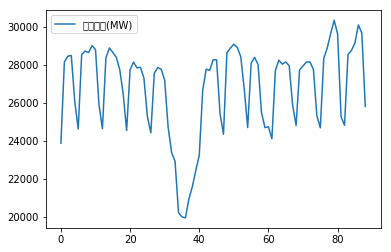

In [4]:
train.plot()

## data preprocessing and feature selection

### 製作訓練集

* 將資料正規化
* 利用前30天的 '尖峰負載(MW)' 作為X_train 
* 而未來7天的 '尖峰負載(MW)' 作為Y_train 
* 將資料打散，目的為使之不要按照日期排序影響訓練
* 先預測3/31,4/1的電力高峰值 
* 最後使用4/2前30天的資料讓模型預測最後得到預測結果

In [5]:
def buildTrain(train):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-37):
        X_train.append(np.array(train.iloc[i:i+30]))
        Y_train.append(np.array(train.iloc[i+30:i+37]["尖峰負載(MW)"]))
    return np.array(X_train), np.array(Y_train)

def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train.drop('date',axis=1))
train_norm = pd.DataFrame(train_norm)
train_norm['尖峰負載(MW)'] = train_norm[0]
train_norm = train_norm.drop(0,axis=1)

# build Data, use last 30 days to predict next 7 days
X_train, Y_train = buildTrain(train_norm)

# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

## 選擇預測模型

* 考慮資料有週期性,故選擇適合處理時間序列問題之模型LSTM(Long Short-Term Memory)
* loss function 選擇 mean_absolute_error
* optimizer 選擇 Adam
* 並使用callback(EarlyStopping)

In [7]:
def lstm_stock_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(30,activation='linear'))
    model.add(Dense(7,activation='linear'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

### 將訓練好的模型儲存成my_model.h5

In [10]:
#model = lstm_stock_model(X_train.shape)
#callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")

#history = model.fit(X_train, Y_train, epochs=1000, batch_size=5, validation_split=0.1, callbacks=[callback],shuffle=True)

#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.show()


#Predict1 = model.predict(np.array(train_norm[54:84]).reshape((1,30,1)))
#print(Predict1)

#model.save('my_model.h5')

### 讀入模型 並預測出3/31以及4/1的高峰值

test after load:  [[0.7707407  0.9479988  0.8074274  0.6603544  0.49367863 0.6526163
  0.7510345 ]]
[[27957.1   29801.822 28338.896 26808.309 25073.713 26727.777 27752.016]]
                       0
2019-03-26  27957.099609
2019-03-27  29801.822266
2019-03-28  28338.896484
2019-03-29  26808.308594
2019-03-30  25073.712891
2019-03-31  26727.777344
2019-04-01  27752.015625


/Users/suchunying/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


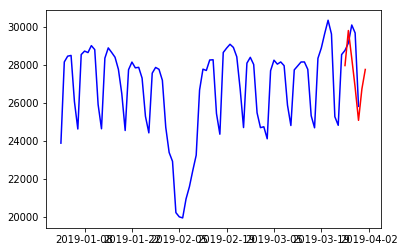

In [11]:
model = load_model('my_model.h5')
print('test after load: ', model.predict(np.array(train_norm[54:84]).reshape((1,30,1))))
Predict1 = model.predict(np.array(train_norm[54:84]).reshape((1,30,1)))
trainPredict = scaler.inverse_transform(Predict1)
print(trainPredict)

def get_date_range(start, limit, level='day',format='YYYY-MM-DD'):
    start = arrow.get(start, format)  
    result=(list(map(lambda dt: dt.format(format) , arrow.Arrow.range(level, start, 		   limit=limit))))
    dateparse2 = lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')
    return map(dateparse2, result)

te = pd.DataFrame(trainPredict).T
te.index = get_date_range('2019-03-26',7)
print(te)
train.index = pd.to_datetime(train['date'])
plt.plot(train['尖峰負載(MW)'],color='blue')
plt.plot(te,color='red')
#plt.show()

te['尖峰負載(MW)'] = te[0]
te = te.drop(0,axis=1)
train = train.append(te['2019-03-31':'2019-04-01'])
data_new = train.drop('date',axis=1)
#print(data_new)

### 最後使用4/2前30天的資料讓模型預測 得到4/2-4/8的預測結果

In [12]:
train_norm1 = scaler.fit_transform(data_new)
train_norm1 = pd.DataFrame(train_norm1)
train_norm1['尖峰負載(MW)'] = train_norm1[0]
train_norm1 = train_norm1.drop(0,axis=1)

# build Data, use last 30 days to predict next 7 days
X_train1, Y_train1 = buildTrain(train_norm1)

# shuffle the data, and random seed is 10
X_train1, Y_train1 = shuffle(X_train1, Y_train1)

Predict2 = model.predict(np.array(train_norm1[61:91]).reshape((1,30,1)))
trainPredict2 = scaler.inverse_transform(Predict2)
#print(trainPredict2)

answer = pd.DataFrame(trainPredict2).T
answer['date'] = range(20190402,20190409)
answer['peak_load(MW)'] = answer[0]
answer = answer.drop(0,axis=1)

answer.to_csv('submission.csv',index=False)

In [13]:
answer

,date,peak_load(MW)
0,20190402,28414.167969
1,20190403,29766.992188
2,20190404,29259.824219
3,20190405,27963.615234
4,20190406,25525.701172
5,20190407,25702.482422
6,20190408,26491.464844
